# Playing with Value Functions as Polytopes


From this paper: https://arxiv.org/pdf/1901.11524.pdf





In [1]:
using Plots
using Random
using Plots; gr()
using ProgressMeter
using Interact
using Colors

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4769386394383922725\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17929445462335468222\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4769386394383922725\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
mutable struct MDP{F<:Number, D<:AbstractFloat}
    size_A::Int
    γ::D
    r̂::Array{F, 1}
    P̂::Array{Array{F, 1}, 1}
end

num_actions(mdp::MDP) = mdp.size_A
num_states(mdp::MDP) = Int(length(mdp.r̂)/mdp.size_A)

rew(mdp::MDP, i, j) = mdp.r̂[(i-1)*num_actions(mdp) + j]
prob(mdp::MDP, k, i, j) = begin
    mdp.P̂[(i-1)*num_actions(mdp) + j][k]
end

MDP2a() = MDP(2, 0.9, [0.06, 0.38, -0.13, 0.64], [[0.01, 0.99], [0.92, 0.08], [0.08, 0.92], [0.70, 0.30]])
MDP2b() = MDP(2, 0.9, [0.88, -0.02, -0.98, 0.42], [[0.96, 0.04], [0.19, 0.81], [0.43, 0.57], [0.72, 0.28]])
MDP2c() = MDP(3, 0.9, [-0.93, -0.49, 0.63, 0.78, 0.14, 0.41], [[0.52, 0.48], [0.5, 0.5], [0.99, 0.01], [0.85, 0.15], [0.11, 0.89], [0.1, 0.9]])
MDP2d() = MDP(2, 0.9, [-0.45, -0.1, 0.5, 0.5], [[0.7, 0.3], [0.99, 0.01], [0.2, 0.8], [0.99, 0.01]])

MDP3left() = MDP(3, 0.8, [-0.1, -1.0, 0.1, 0.4, 1.5, 0.1], [[0.9, 0.1], [0.2, 0.8], [0.7, 0.3], [0.05, 0.95], [0.25, 0.75], [0.3, 0.7]])
MDP3right() = MDP(2, 0.9, [-0.45, -0.1, 0.5, 0.5], [[0.7, 0.3], [0.99, 0.01], [0.2, 0.8], [0.99, 0.01]])


function sample_random_policy(mdp::MDP, rng=Random.GLOBAL_RNG)
    ns = num_states(mdp)
    na = num_actions(mdp)
    π = rand(rng, na, ns)
    for i ∈ 1:ns
        π[:, i]./=sum(π[:, i])
    end
    π
end

function get_set_policies(mdp, diff=0.05)
    ns = num_states(mdp)
    na = num_actions(mdp)
    iter = Iterators.product((0.0:diff:1.0 for i in 1:na)...)
    policies = Array{Array{Float64, 2}, 1}(undef, length(iter))
    for (p_idx, p) in enumerate(Iterators.product((0.0:diff:1.0 for i in 1:na)...))
        policy = zeros(na, ns)
        policy[1, :] .= p
        policy[2, :] .= 1.0 .- p
        policies[p_idx] = policy
    end
    policies
end

function policy_evaluation(mdp::MDP, policy, n=100)
    ns = num_states(mdp)
    na = num_actions(mdp)
    v = zeros(ns)
    for i in 1:n
        prev_v = copy(v)
        for s in 1:ns
            v[s] = sum(policy[a, s]*sum(prob(mdp, s′, s, a)*(rew(mdp, s, a) + mdp.γ*prev_v[s′]) for s′ in 1:ns) for a in 1:na)
        end
    end
    v
end

function policy_evaluation(mdp::MDP, policy, γ::AbstractFloat, n=100)
    ns = num_states(mdp)
    na = num_actions(mdp)
    v = zeros(ns)
    for i in 1:n
        prev_v = copy(v)
        for s in 1:ns
            v[s] = sum(policy[a, s]*sum(prob(mdp, s′, s, a)*(rew(mdp, s, a) + γ*prev_v[s′]) for s′ in 1:ns) for a in 1:na)
        end
    end
    v
end

function policy_evaluation(mdp::MDP, policy, γ::Array{<:AbstractFloat,1}, n=100)
    ns = num_states(mdp)
    na = num_actions(mdp)
    v = zeros(ns)
    for i in 1:n
        prev_v = copy(v)
        for s in 1:ns
            v[s] = sum(policy[a, s]*sum(prob(mdp, s′, s, a)*(rew(mdp, s, a) + γ[s′]*prev_v[s′]) for s′ in 1:ns) for a in 1:na)
        end
    end
    v
end

    

policy_evaluation (generic function with 6 methods)

In [3]:
mdp = MDP2c()
sample_random_policy(mdp)

3×2 Array{Float64,2}:
 0.443445  0.465309
 0.316959  0.290637
 0.239596  0.244054

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


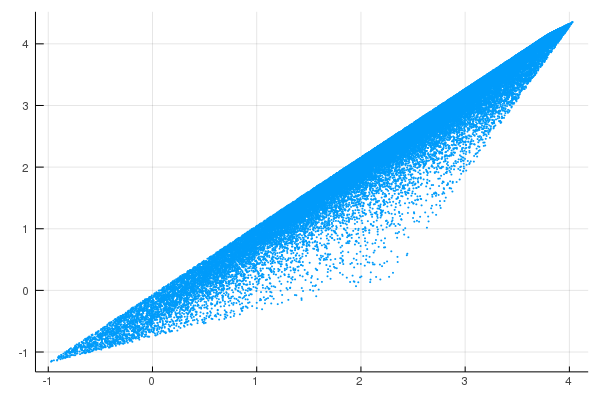

In [4]:
mdp = MDP2a()
num_policies = 50000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values = Array{Array{Float64, 1}, 1}(undef, num_policies)
prg_bar = Progress(num_policies)
Threads.@threads for i in 1:num_policies
    values[i] = policy_evaluation(mdp, policies[i], 1000)
    next!(prg_bar)
end
scatter(getindex.(values,1), getindex.(values,2), labels="", markersize=2, markerstrokewidth=0, fmt=:png)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


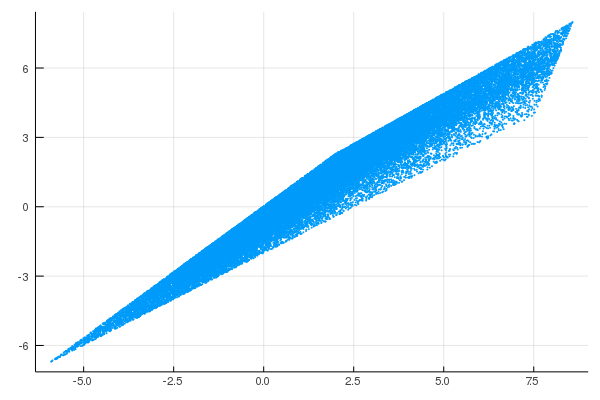

In [5]:
mdp = MDP2b()
num_policies = 50000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values = Array{Array{Float64, 1}, 1}(undef, num_policies)
prg_bar = Progress(num_policies)
Threads.@threads for i in 1:num_policies
    values[i] = policy_evaluation(mdp, policies[i], 1000)
    next!(prg_bar)
end
scatter(getindex.(values,1), getindex.(values,2), labels="", markersize=2, markerstrokewidth=0, fmt=:png)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


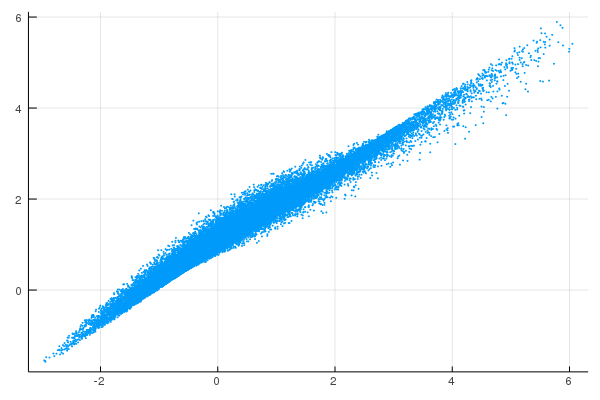

In [6]:
mdp = MDP2c()
num_policies = 50000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values = Array{Array{Float64, 1}, 1}(undef, num_policies)
prg_bar = Progress(num_policies)
Threads.@threads for i in 1:num_policies
    values[i] = policy_evaluation(mdp, policies[i], 1000)
    next!(prg_bar)
end
scatter(getindex.(values,1), getindex.(values,2), labels="", markersize=2, markerstrokewidth=0, fmt=:png)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


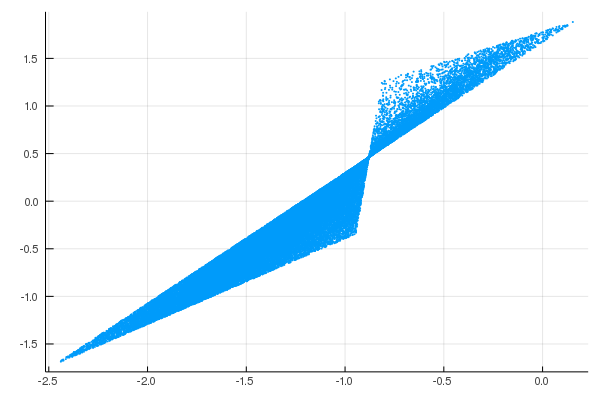

In [7]:
mdp = MDP2d()
num_policies = 50000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values = Array{Array{Float64, 1}, 1}(undef, num_policies)
prg_bar = Progress(num_policies)
Threads.@threads for i in 1:num_policies
    values[i] = policy_evaluation(mdp, policies[i], 1000)
    next!(prg_bar)
end
scatter(getindex.(values,1), getindex.(values,2), labels="", markersize=2, markerstrokewidth=0, fmt=:png)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


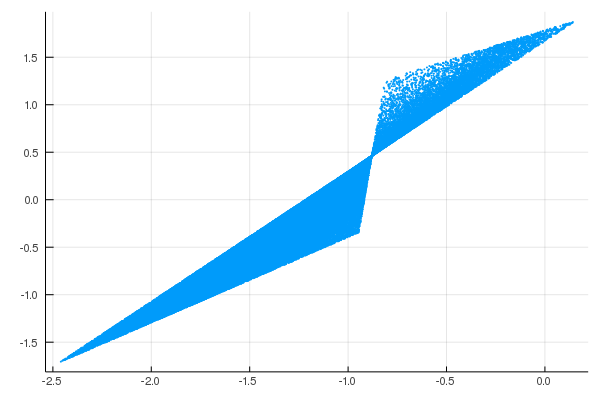

In [8]:
# Random.seed!(0)
mdp = MDP3right()
num_policies = 100000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
# policies = get_set_policies(mdp, 0.05)
values = Array{Array{Float64, 1}, 1}(undef, num_policies)
prg_bar = Progress(num_policies)
Threads.@threads for i in 1:num_policies
    values[i] = policy_evaluation(mdp, policies[i], 1000)
    next!(prg_bar)
end
scatter(getindex.(values,1), getindex.(values,2), labels="", markersize=2, markerstrokewidth=0, fmt=:png)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


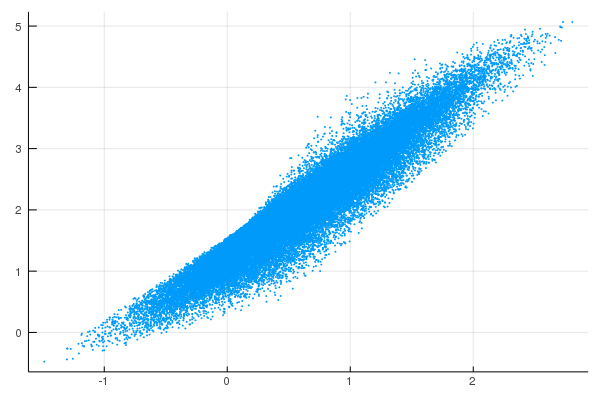

In [9]:
mdp = MDP3left()
num_policies = 50000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values = Array{Array{Float64, 1}, 1}(undef, num_policies)
prg_bar = Progress(num_policies)
Threads.@threads for i in 1:num_policies
    values[i] = policy_evaluation(mdp, policies[i], 1000)
    next!(prg_bar)
end
scatter(getindex.(values,1), getindex.(values,2), labels="", markersize=2, markerstrokewidth=0, fmt=:png)

In [18]:
Random.seed!(0)
mdp = MDP3right()
gammas = 0.0:0.01:0.99
num_gammas = length(gammas)
num_policies = 5000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
# policies = get_set_policies(mdp, 0.05)
values = Array{Array{Float64, 1}}(undef, num_policies, num_gammas)

prg_bar_policy = Progress(num_policies, desc="Policy: ")
Threads.@threads for j in 1:num_policies
    @simd for i in 1:num_gammas
        values[j, i] = policy_evaluation(mdp, policies[j], gammas[i], 1000)
    end
    next!(prg_bar_policy)
end

# plts = [scatter(getindex.(values[:, i],1), getindex.(values[:, i],2), labels="", markersize=2, markerstrokewidth=0, fmt=:png) for i in 1:num_gammas]

Policy: 100%|███████████████████████████████████████████| Time: 0:05:52


In [25]:
# colors = rand(RGB, num_policies)
colors = fill(:blue, num_policies)
ms = fill(2, num_policies)

val, idx = findmax(sum.(values[:, end]))
colors[idx] = :green
ms[idx] = 4

@manipulate for i in 1:num_gammas
    scatter(getindex.(values[:, i],1), getindex.(values[:, i],2), title="$(gammas[i])", labels="", markersize=ms, markerstrokewidth=0, fmt=:png, color=colors)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
50, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/Matt/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/Matt/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/Matt/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/Matt/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/Matt/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001111c0490, Task (runnable) @0x00000001111c0490), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"

In [12]:
policies[idx]

2×2 Array{Float64,2}:
 0.896519  0.991608 
 0.103481  0.0083919

In [13]:
Random.seed!(0)
mdp = MDP3right()
num_policies = 5000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values = Array{Array{Float64, 1}}(undef, num_policies)
gamma = [1.0, 0.0]

prg_bar_policy = Progress(num_policies, desc="Policy: ")
Threads.@threads for j in 1:num_policies
    values[j] = policy_evaluation(mdp, policies[j], gamma, 1000)
    next!(prg_bar_policy)
end

Policy: 100%|███████████████████████████████████████████| Time: 0:00:03


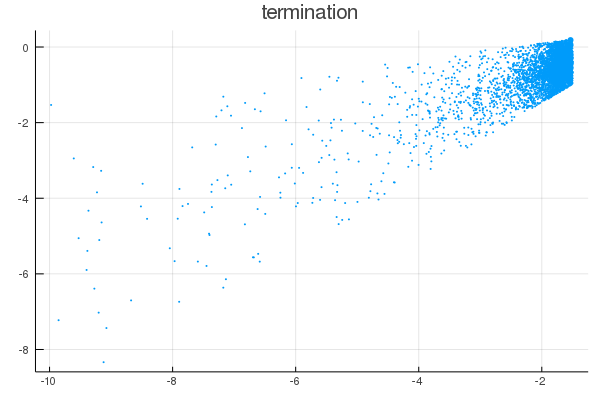

In [14]:
scatter(getindex.(values,1), getindex.(values,2), title="termination", labels="", markersize=ms, markerstrokewidth=0, fmt=:png)

In [15]:
Random.seed!(0)
mdp = MDP3right()
num_policies = 5000
policies = [sample_random_policy(mdp) for i in 1:num_policies]
values_2 = Array{Array{Float64, 1}}(undef, num_policies)
gamma = [0.0, 1.0]

prg_bar_policy = Progress(num_policies, desc="Policy: ")
Threads.@threads for j in 1:num_policies
    values_2[j] = policy_evaluation(mdp, policies[j], gamma, 1000)
    next!(prg_bar_policy)
end

Policy: 100%|███████████████████████████████████████████| Time: 0:00:03


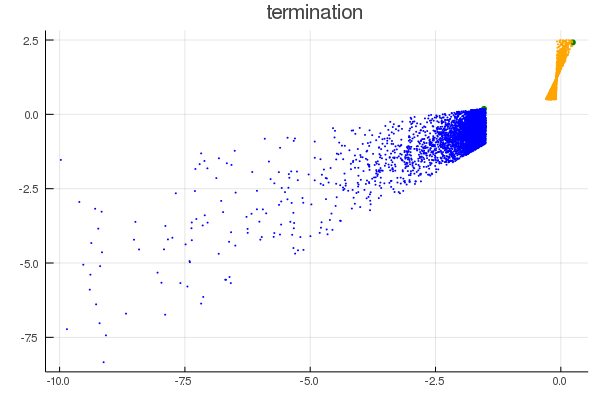

In [16]:
colors = fill(:blue, num_policies)
colors[idx] = :green

scatter(getindex.(values,1), getindex.(values,2), title="termination", labels="", markersize=ms, markerstrokewidth=0, fmt=:png, color=colors)

colors = fill(:orange, num_policies)
colors[idx] = :green
scatter!(getindex.(values_2,1), getindex.(values_2,2), title="termination", labels="", markersize=ms, markerstrokewidth=0, fmt=:png, color=colors)